In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import pytensor.tensor as pt

from scipy import stats
from scipy.optimize import curve_fit
import scipy.io as scio 

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.97  # sets default credible interval used by arviz
np.random.seed(0)

In [3]:
data_file = r"F:\YuLab\Work\GPS\Video\Kennard\GPS_07_Kornblum1000SRTSelf\TrialInfo_Kennard_KornblumSRT_z.csv"

In [4]:
d = pd.read_csv(data_file)
d.head()

,Session,Treatment,Dose,Label,Trial,Stage,Cued,Performance,PortCorrect,PortChosen,RT,MT,HD,zi,MotorType
0,20230915,Saline,1.0,Control,11,1,0,Correct,R,R,0.1714,0.7690,1.1714,1.0,1.0
1,20230915,Saline,1.0,Control,12,1,0,Correct,R,R,0.2405,0.6503,1.2404,1.0,0.0
2,20230915,Saline,1.0,Control,13,1,0,Premature,R,NaN,NaN,NaN,0.9390,1.0,0.0
3,20230915,Saline,1.0,Control,14,1,0,Correct,L,L,0.1692,0.3510,1.1691,1.0,0.0
4,20230915,Saline,1.0,Control,15,1,0,Correct,R,R,0.1838,0.5747,1.1838,1.0,0.0


In [5]:
d = d.loc[d["Cued"]==0, ["Label", "HD", "PortCorrect", "MotorType"]]
d.reset_index(inplace = True, drop = True)

In [6]:
d = d.loc[d["MotorType"].isin([0, 1])]
d.reset_index(inplace = True, drop = True)
d.head()

,Label,HD,PortCorrect,MotorType
0,Control,1.1714,R,1.0
1,Control,1.2404,R,0.0
2,Control,0.9390,R,0.0
3,Control,1.1691,L,0.0
4,Control,1.1838,R,0.0


In [7]:
hold_duration = np.array(d["HD"])
treatment = np.array(d["Label"].isin(["Chemo"]).astype('int'))
port_correct = np.array(d["PortCorrect"].isin(["L"]).astype('int'))
motor_type = np.array(d["MotorType"])

num_trials = len(treatment)

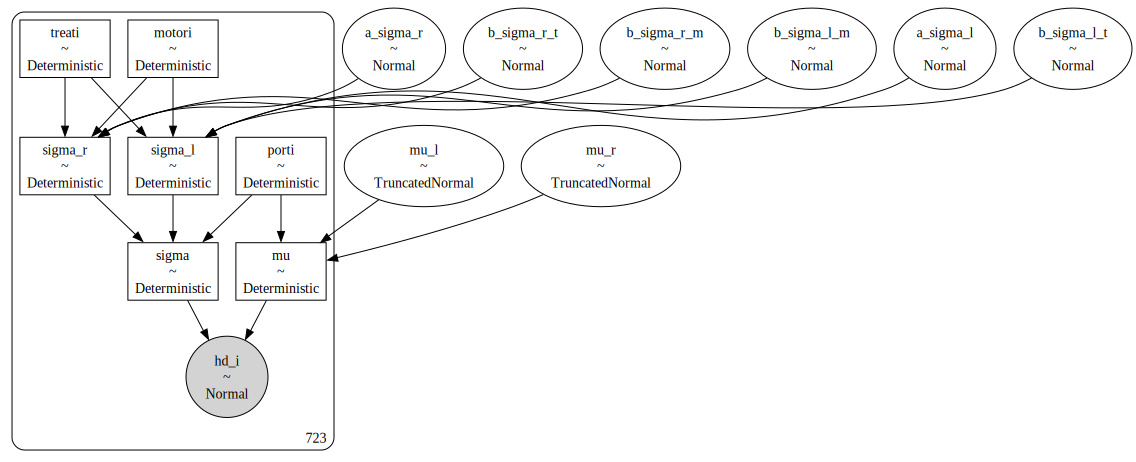

In [8]:
with pm.Model() as model_treatmeant_motor:

    porti = pm.Deterministic("porti", pt.switch(pt.eq(port_correct, 1), 0, 1) ) # 0 - l; 1 - r
    treati = pm.Deterministic("treati", pt.switch(pt.eq(treatment, 0), 0, 1))
    motori = pm.Deterministic("motori", pt.switch(pt.eq(motor_type, 0), 0, 1))

    # prior
    mu_l = pm.TruncatedNormal("mu_l", mu=1., sigma=0.5, lower=0.)
    mu_r = pm.TruncatedNormal("mu_r", mu=1., sigma=0.5, lower=0.)

    a_log_sigma_l = pm.Normal("a_sigma_l", sigma=.5)
    a_log_sigma_r = pm.Normal("a_sigma_r", sigma=.5)
    b_log_sigma_l_t = pm.Normal("b_sigma_l_t", sigma=.5)
    b_log_sigma_r_t = pm.Normal("b_sigma_r_t", sigma=.5)
    b_log_sigma_l_m = pm.Normal("b_sigma_l_m", sigma=.5)
    b_log_sigma_r_m = pm.Normal("b_sigma_r_m", sigma=.5)

    log_sigma_l = pm.Deterministic("sigma_l", a_log_sigma_l + b_log_sigma_l_t * treati + b_log_sigma_l_m * motori)
    log_sigma_r = pm.Deterministic("sigma_r", a_log_sigma_r + b_log_sigma_r_t * treati + b_log_sigma_r_m * motori)

    mu = pm.Deterministic("mu", (1-porti) * mu_l + porti * mu_r )
    sigma = pm.Deterministic("sigma", (1-porti) * pt.exp(log_sigma_l) + porti * pt.exp(log_sigma_r) )
    
    # mum and mub were meant to be 1-mum and 1-mub in the original PyMC3 codes
    # mum = pm.Deterministic("mum", 1 / (1 + pt.exp(pt.log(1 / mub - 1) + mud)))
    # Following the code in the book, mum is defined as

    # observed
    hd_i = pm.Normal("hd_i", mu=mu, sigma=sigma, observed=hold_duration)

pm.model_to_graphviz(model_treatmeant_motor)

In [9]:
with model_treatmeant_motor:
    trace_treatmeant_motor = pm.sample(chains=4, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_l, mu_r, a_sigma_l, a_sigma_r, b_sigma_l_t, b_sigma_r_t, b_sigma_l_m, b_sigma_r_m]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 21 seconds.


In [10]:
az.summary(trace_treatmeant_motor, var_names=["mu_l", "mu_r", "a_sigma_l", "a_sigma_r", "b_sigma_l_t", "b_sigma_r_t", "b_sigma_l_m", "b_sigma_r_m"])

,mean,sd,hdi_1.5%,hdi_98.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_l,1.177,0.009,1.157,1.196,0.000,0.000,9362.0,5901.0,1.0
mu_r,1.107,0.009,1.088,1.126,0.000,0.000,10695.0,5048.0,1.0
a_sigma_l,-1.969,0.051,-2.077,-1.857,0.001,0.000,9912.0,5376.0,1.0
a_sigma_r,-1.976,0.052,-2.091,-1.868,0.001,0.000,9947.0,6113.0,1.0
b_sigma_l_t,1.189,0.155,0.864,1.520,0.002,0.001,7471.0,5606.0,1.0
b_sigma_r_t,0.518,0.140,0.217,0.824,0.002,0.001,6281.0,5426.0,1.0
b_sigma_l_m,-0.477,0.155,-0.795,-0.137,0.002,0.001,7635.0,5572.0,1.0
b_sigma_r_m,-0.076,0.140,-0.383,0.221,0.002,0.001,6801.0,5706.0,1.0


In [11]:
with pm.Model() as model_motor:

    porti = pm.Deterministic("porti", pt.switch(pt.eq(port_correct, 1), 0, 1) ) # 0 - l; 1 - r
    motori = pm.Deterministic("motori", pt.switch(pt.eq(motor_type, 0), 0, 1))

    # prior
    mu_l = pm.TruncatedNormal("mu_l", mu=1., sigma=0.5, lower=0.)
    mu_r = pm.TruncatedNormal("mu_r", mu=1., sigma=0.5, lower=0.)

    a_log_sigma_l = pm.Normal("a_sigma_l", sigma=.5)
    a_log_sigma_r = pm.Normal("a_sigma_r", sigma=.5)
    b_log_sigma_l_m = pm.Normal("b_sigma_l_m", sigma=.5)
    b_log_sigma_r_m = pm.Normal("b_sigma_r_m", sigma=.5)

    log_sigma_l = pm.Deterministic("sigma_l", a_log_sigma_l + b_log_sigma_l_m * motori)
    log_sigma_r = pm.Deterministic("sigma_r", a_log_sigma_r + b_log_sigma_r_m * motori)

    mu = pm.Deterministic("mu", (1-porti) * mu_l + porti * mu_r )
    sigma = pm.Deterministic("sigma", (1-porti) * pt.exp(log_sigma_l) + porti * pt.exp(log_sigma_r) )
    
    # mum and mub were meant to be 1-mum and 1-mub in the original PyMC3 codes
    # mum = pm.Deterministic("mum", 1 / (1 + pt.exp(pt.log(1 / mub - 1) + mud)))
    # Following the code in the book, mum is defined as

    # observed
    hd_i = pm.Normal("hd_i", mu=mu, sigma=sigma, observed=hold_duration)


In [12]:
with model_motor:
    trace_motor = pm.sample(chains=4, draws=2000, tune=2000)

az.summary(trace_motor, var_names=["mu_l", "mu_r", "a_sigma_l", "a_sigma_r", "b_sigma_l_m", "b_sigma_r_m"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_l, mu_r, a_sigma_l, a_sigma_r, b_sigma_l_m, b_sigma_r_m]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.


,mean,sd,hdi_1.5%,hdi_98.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_l,1.188,0.011,1.164,1.213,0.000,0.000,8054.0,6284.0,1.0
mu_r,1.112,0.009,1.093,1.131,0.000,0.000,8100.0,6153.0,1.0
a_sigma_l,-1.686,0.050,-1.795,-1.578,0.001,0.000,7278.0,5859.0,1.0
a_sigma_r,-1.901,0.051,-2.005,-1.786,0.001,0.000,7282.0,6205.0,1.0
b_sigma_l_m,0.411,0.075,0.251,0.574,0.001,0.001,7036.0,6334.0,1.0
b_sigma_r_m,0.340,0.079,0.166,0.506,0.001,0.001,7324.0,6066.0,1.0


In [13]:
with pm.Model() as model_treatmeant:

    porti = pm.Deterministic("porti", pt.switch(pt.eq(port_correct, 1), 0, 1) ) # 0 - l; 1 - r
    treati = pm.Deterministic("treati", pt.switch(pt.eq(treatment, 0), 0, 1))

    # prior
    mu_l = pm.TruncatedNormal("mu_l", mu=1., sigma=0.5, lower=0.)
    mu_r = pm.TruncatedNormal("mu_r", mu=1., sigma=0.5, lower=0.)

    a_log_sigma_l = pm.Normal("a_sigma_l", sigma=.5)
    a_log_sigma_r = pm.Normal("a_sigma_r", sigma=.5)
    b_log_sigma_l_t = pm.Normal("b_sigma_l_t", sigma=.5)
    b_log_sigma_r_t = pm.Normal("b_sigma_r_t", sigma=.5)

    log_sigma_l = pm.Deterministic("sigma_l", a_log_sigma_l + b_log_sigma_l_t * treati)
    log_sigma_r = pm.Deterministic("sigma_r", a_log_sigma_r + b_log_sigma_r_t * treati)

    mu = pm.Deterministic("mu", (1-porti) * mu_l + porti * mu_r )
    sigma = pm.Deterministic("sigma", (1-porti) * pt.exp(log_sigma_l) + porti * pt.exp(log_sigma_r) )
    
    # mum and mub were meant to be 1-mum and 1-mub in the original PyMC3 codes
    # mum = pm.Deterministic("mum", 1 / (1 + pt.exp(pt.log(1 / mub - 1) + mud)))
    # Following the code in the book, mum is defined as

    # observed
    hd_i = pm.Normal("hd_i", mu=mu, sigma=sigma, observed=hold_duration)

In [14]:
with model_treatmeant:
    trace_treatmeant = pm.sample(chains=4, draws=2000, tune=2000)

az.summary(trace_treatmeant, var_names=["mu_l", "mu_r", "a_sigma_l", "a_sigma_r", "b_sigma_l_t", "b_sigma_r_t"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_l, mu_r, a_sigma_l, a_sigma_r, b_sigma_l_t, b_sigma_r_t]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.


,mean,sd,hdi_1.5%,hdi_98.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_l,1.181,0.009,1.162,1.202,0.000,0.000,7931.0,6028.0,1.0
mu_r,1.107,0.009,1.088,1.126,0.000,0.000,7989.0,5752.0,1.0
a_sigma_l,-1.981,0.050,-2.089,-1.870,0.001,0.000,7063.0,5909.0,1.0
a_sigma_r,-1.979,0.052,-2.097,-1.870,0.001,0.000,7470.0,6328.0,1.0
b_sigma_l_t,0.796,0.074,0.629,0.949,0.001,0.001,6925.0,5887.0,1.0
b_sigma_r_t,0.453,0.078,0.285,0.626,0.001,0.001,7456.0,6064.0,1.0
